In [2]:
# Created 2017, Zack Gainsforth
%pylab inline
import sys, os
#import QuickPlot
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = 8, 6  # that's default image size for this interactive session
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from ipywidgets.widgets import interactive, fixed, interact
%config InlineBackend.figure_format = 'retina'
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import NMF, PCA, FastICA
from sklearn.pipeline import Pipeline
from tabulate import tabulate
#from ncempy.io import mrc
from scipy.signal import medfilt
#import tifffile
import hyperspy.api as hs
import dask.array as da

Populating the interactive namespace from numpy and matplotlib


Stack dimensions are: (512, 512, 2048).
New stack dimensions are: (128, 128, 2048) with binning: 4
The shape of the OD stack is (2048, 128, 128)


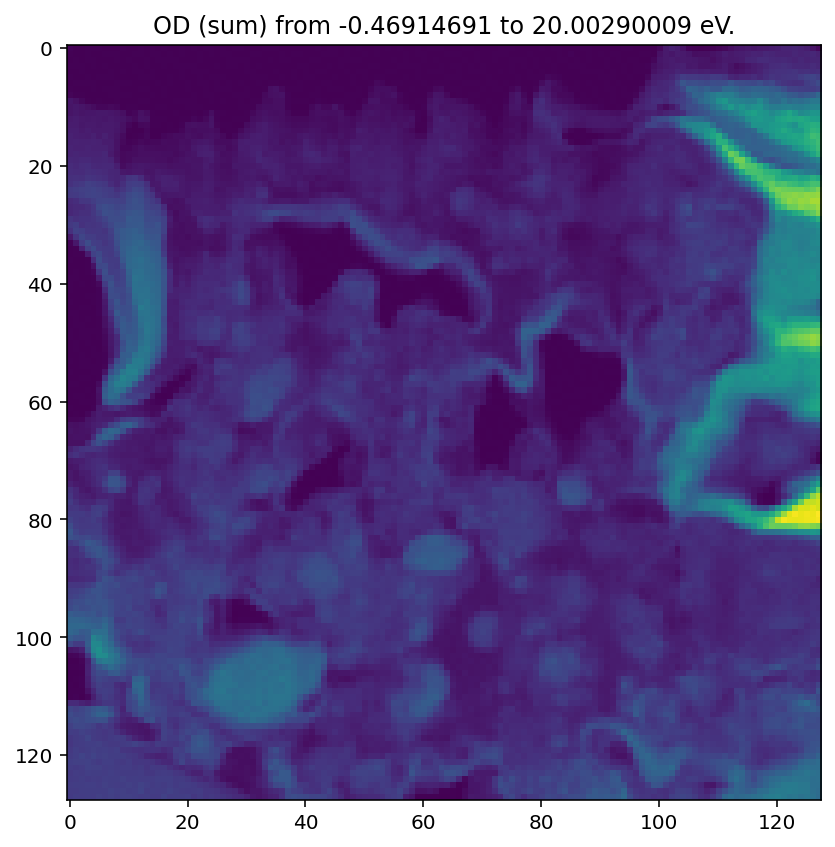

In [3]:
StackName = 'Stack 3.bcf'
BinningFactor = 4

# Read in the OD/phase stacks.
#ODRaw = tifffile.imread(os.path.join('NS_191101034 OD align crop.tif'))
#E = np.genfromtxt(os.path.join('NS_191101034_energies.txt'))

HAADF, EDS = hs.load(StackName)
print(f'Stack dimensions are: {EDS.data.shape}.')
if BinningFactor > 1:
    EDS = EDS.rebin(scale=(BinningFactor, BinningFactor, 1))
    print(f'New stack dimensions are: {EDS.data.shape} with binning: {BinningFactor}')
ODRaw = EDS.data.copy()
ODRaw = np.moveaxis(ODRaw,-1,0) # Move the energy axis from the last axis (slowest) to the zeroth (fast axis)
E = EDS.axes_manager["Energy"].index2value(range(EDS.data.shape[-1]))
print(f'The shape of the OD stack is {ODRaw.shape}')
      
ODSum = np.sum(ODRaw, axis=0)
      
fig,ax = plt.subplots(1,1)
fig.patch.set_alpha(1)
ax.imshow(ODSum)
ax.set_title(f'OD (sum) from {E[0]} to {E[-1]} eV.')
plt.tight_layout()
plt.savefig('ODSum.png', dpi=300)
#os.system('/Users/Zack/.iterm2/imgcat ODSum.png')
plt.show()

In [4]:
#ODRaw

In [5]:
#Full = ODRaw

#medkern = 1
#print(f'Smoothing with median filter kernel {medkern}')
#def dask_median(x):
#    return medfilt(x,kernel_size=(1,medkern,medkern))

#ODTemp = ODRaw.map_overlap(dask_median, depth=medkern)
#ODTemp
#Full = ODTemp.compute()
#Full.shape

#Full = medfilt(Full,kernel_size=(1,medkern,medkern))

#Dat = Full.reshape(Full.shape[0], np.prod(Full.shape[1:])).T
#print(f'The List of spectra for ML has shape {Dat.shape}')

#plt.imshow(np.sum(Full, axis=0))

The List of spectra for ML has shape (16384, 2048)


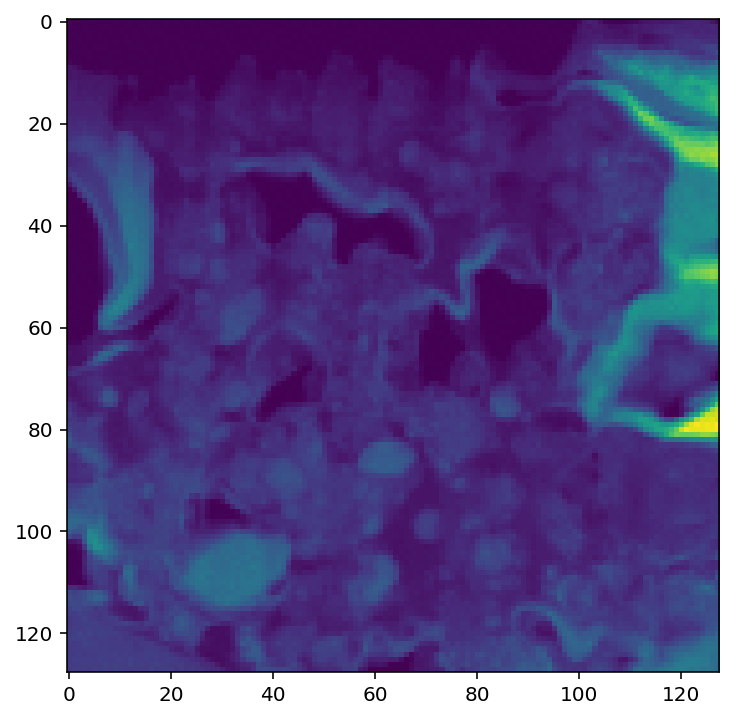

In [6]:
Full = ODRaw

medkern = 1
#print(f'Smoothing with median filter kernel {medkern}')
#Full = medfilt(Full,kernel_size=(1,medkern,medkern))

Dat = Full.reshape(Full.shape[0], np.prod(Full.shape[1:])).T
print(f'The List of spectra for ML has shape {Dat.shape}')

plt.imshow(np.sum(Full, axis=0))

In [7]:
np.random.seed(5)

scale = MinMaxScaler()
#scale = StandardScaler() # Cannot be used with NMF
#scale = RobustScaler() # Cannot be used with NMF
#pca = PCA(n_components=5); OutputDir='PCA'
#pca = FastICA(n_components=6); OutputDir='ICA'
pca = NMF(n_components=5); OutputDir='NMF'
pipe = Pipeline(steps=[('scale', scale), ('pca', pca)])

OutputDir += str(pca.n_components)
if not os.path.exists(OutputDir):
    os.mkdir(OutputDir)

logDat = np.log(Dat - np.min(Dat) + 1)
pipe.fit(logDat)
if(type(pca) not in [FastICA, NMF]):
    plt.plot(pca.explained_variance_)

/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/opt/miniconda3/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [8]:
pca.components_[0,97]

3.0575930417822246

In [9]:
NormComponents = pca.components_.copy()
NormComponents = NormComponents/np.sum(NormComponents, axis=1)[:,np.newaxis]
#print(tabulate(NormComponents, showindex=True, tablefmt='orgtbl'))

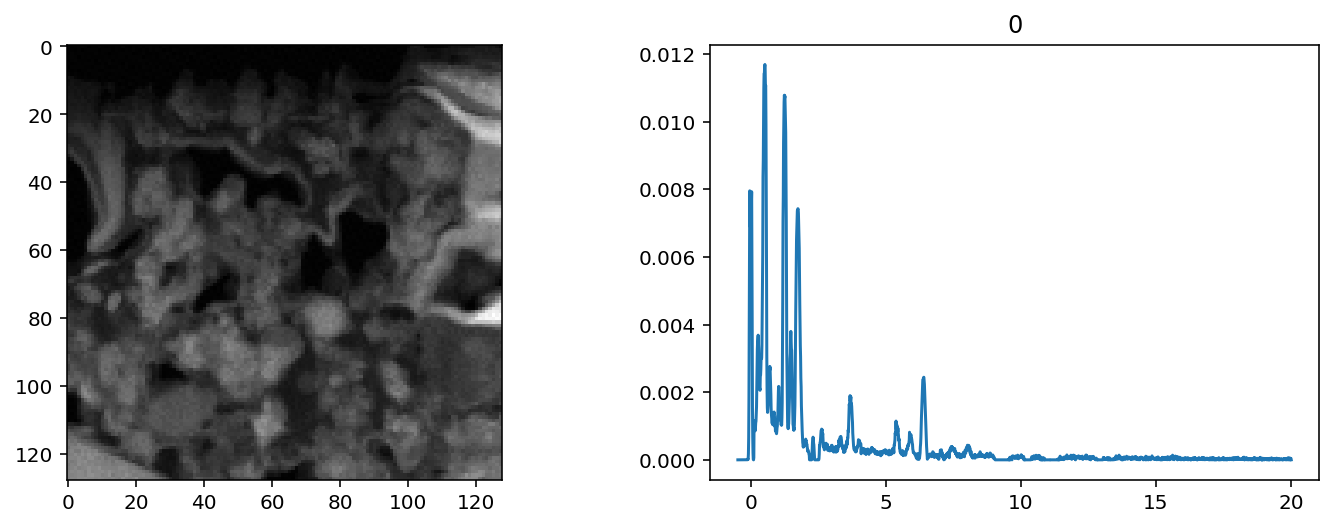

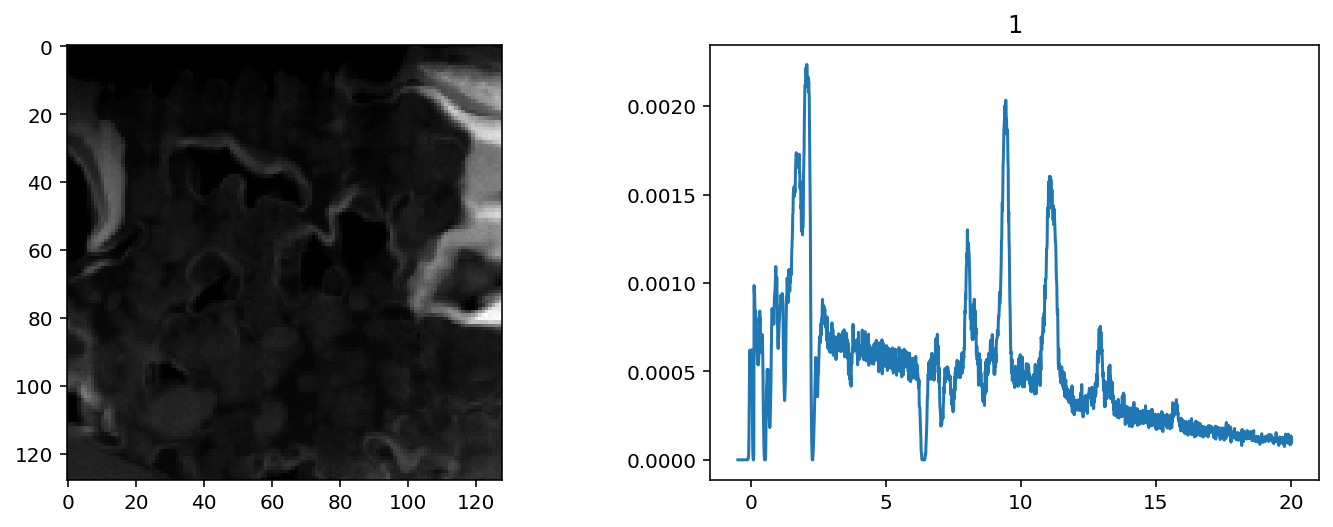

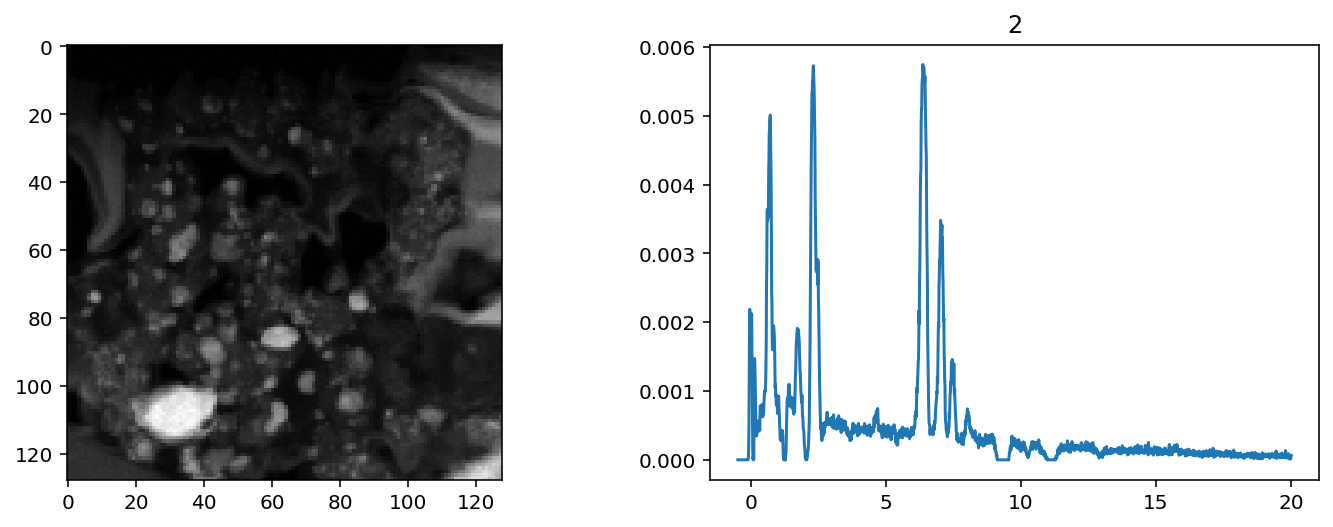

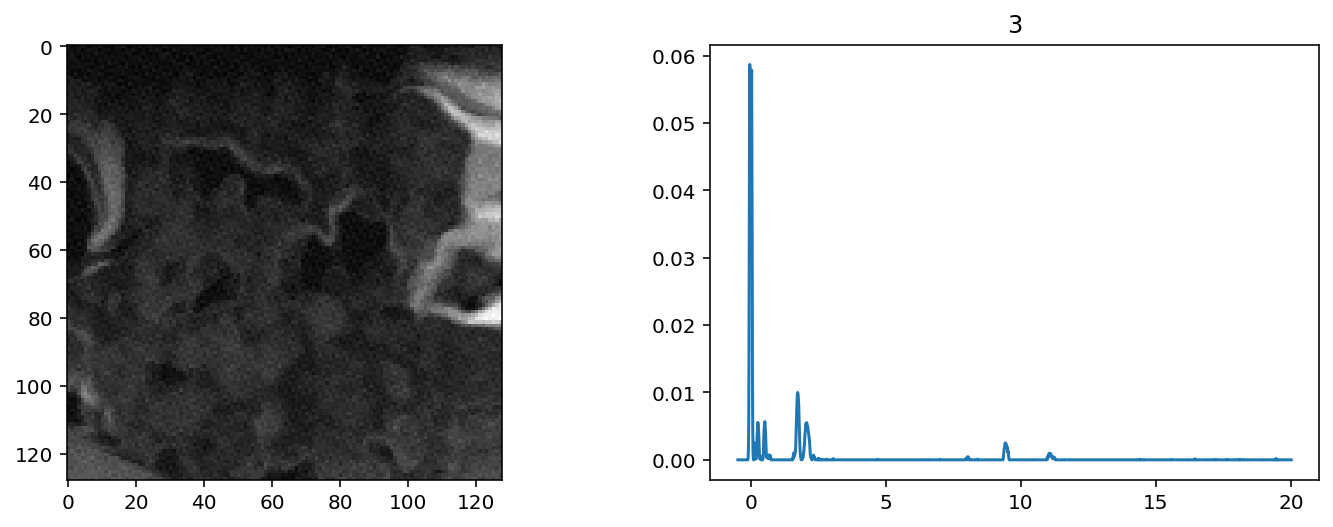

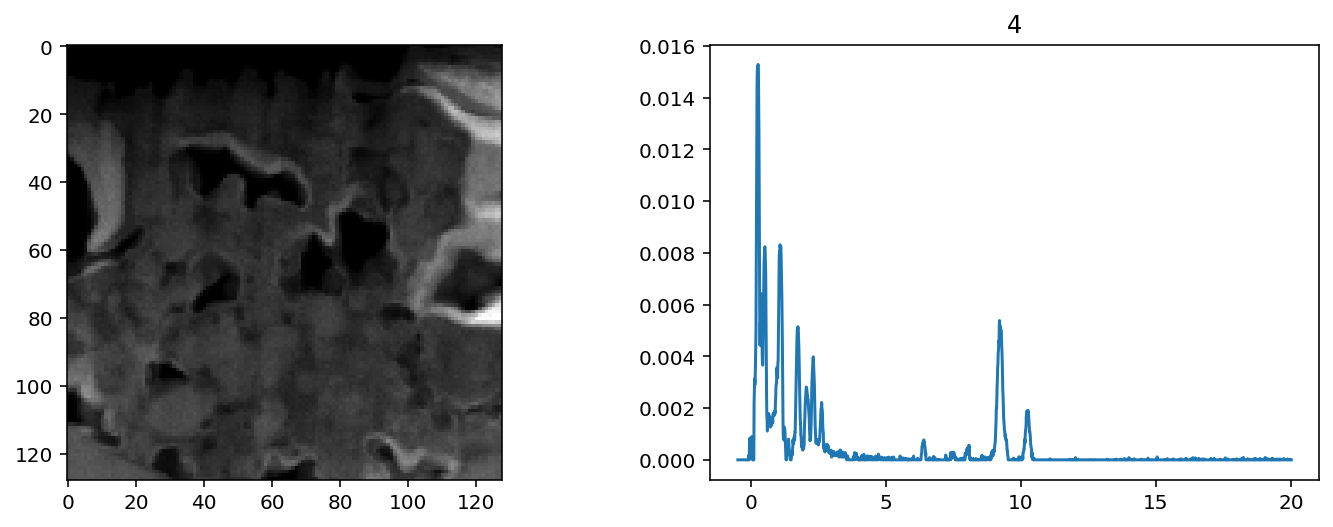

In [10]:
phases = []
for n in range(len(pca.components_)):
    comps = pca.components_[n]
    p = np.dot(Dat, comps)
    phases.append(p.reshape(Full.shape[1:]))
    fig,ax = plt.subplots(1,2, figsize=(12,4))
    fig.patch.set_alpha(1)
    ax[0].imshow(phases[n], cmap='gray')
    ax[1].plot(E, NormComponents[n,:])
    ax[1].set_title(str(n))
    plt.imsave(os.path.join(OutputDir,'phase'+str(n)+'.png'), phases[n], cmap='gray')
    #colorbar()
plt.show()

[0 1 2 3 4]


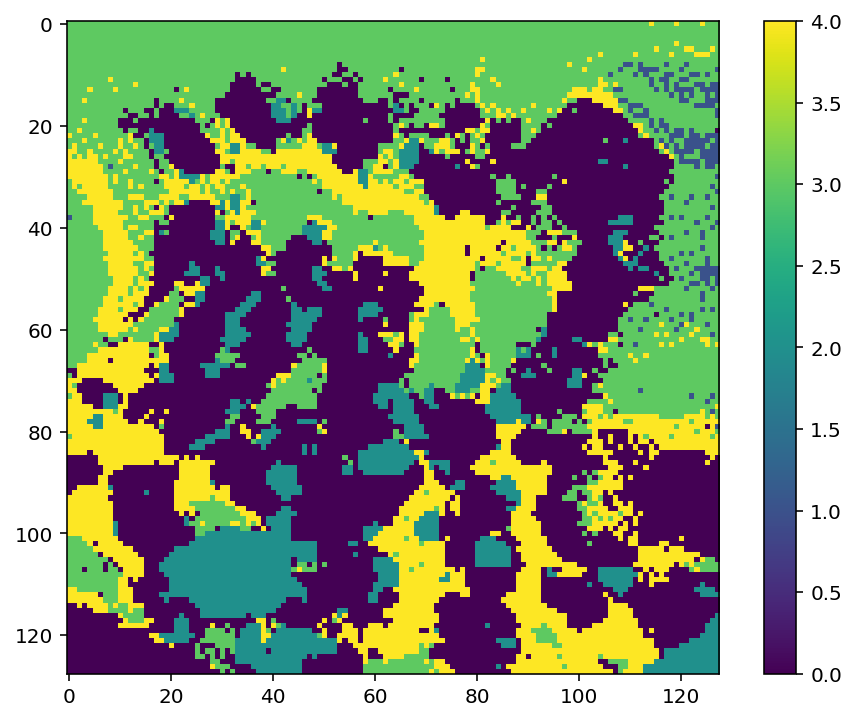

In [11]:
phases2 = np.array(phases)
if(type(pca) != FastICA):
    for i in range(phases2.shape[0]):
        phases2[i,:,:] -= np.min(phases2[i,:,:])
        phases2[i,:,:] /= np.max(phases2[i,:,:])
phaselegend = np.argmax(phases2, axis=0)
imshow(phaselegend, cmap='viridis')
#imshow(medfilt(np.array(phases),kernel_size=(1,13,13))[1])
colorbar()
print(np.unique(phaselegend))
plt.savefig(os.path.join(OutputDir, f'AllPhasesMasks.png'), dpi=300)
plt.show()

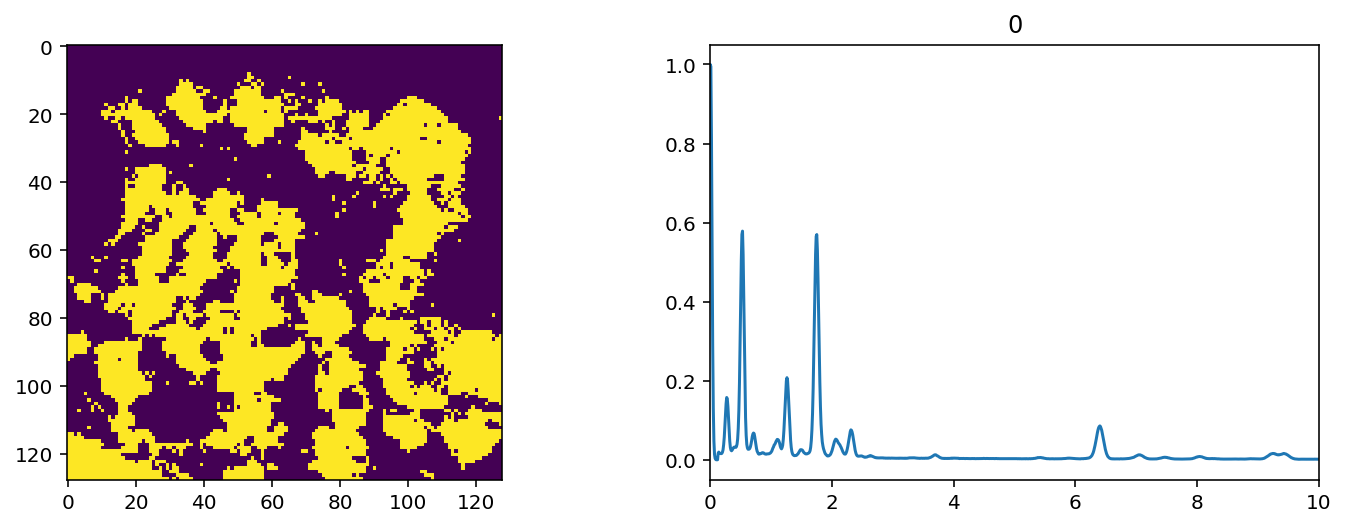

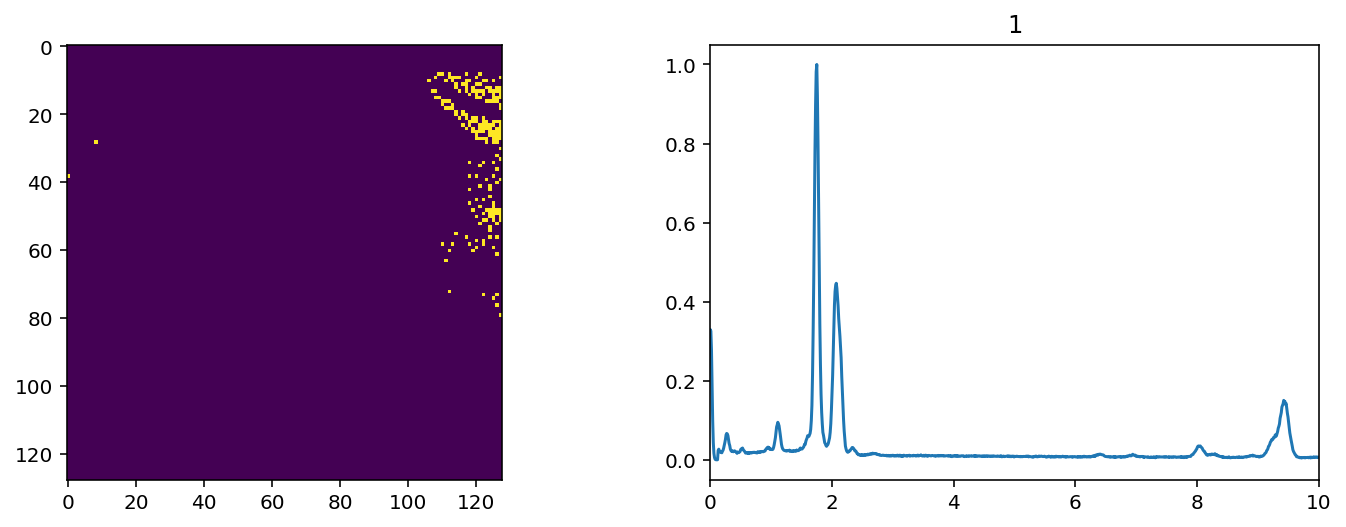

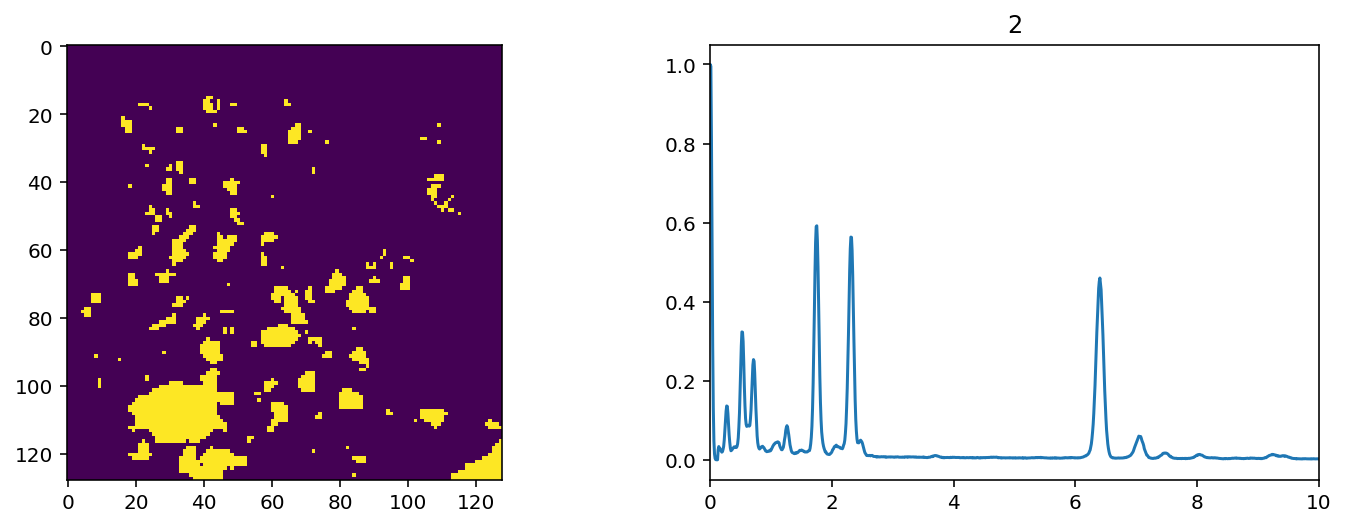

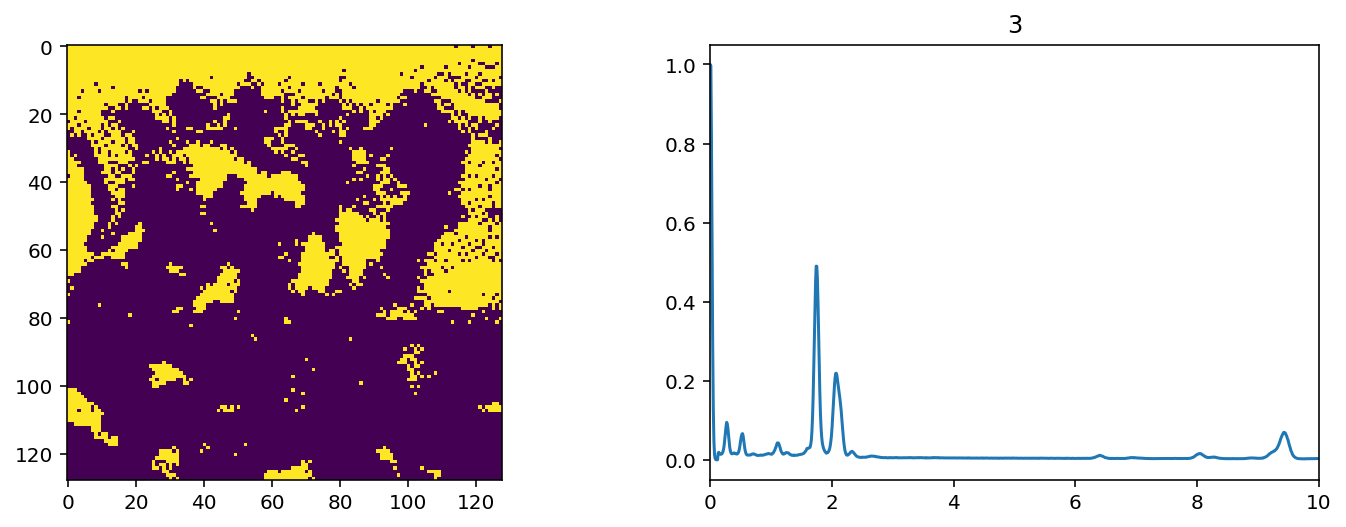

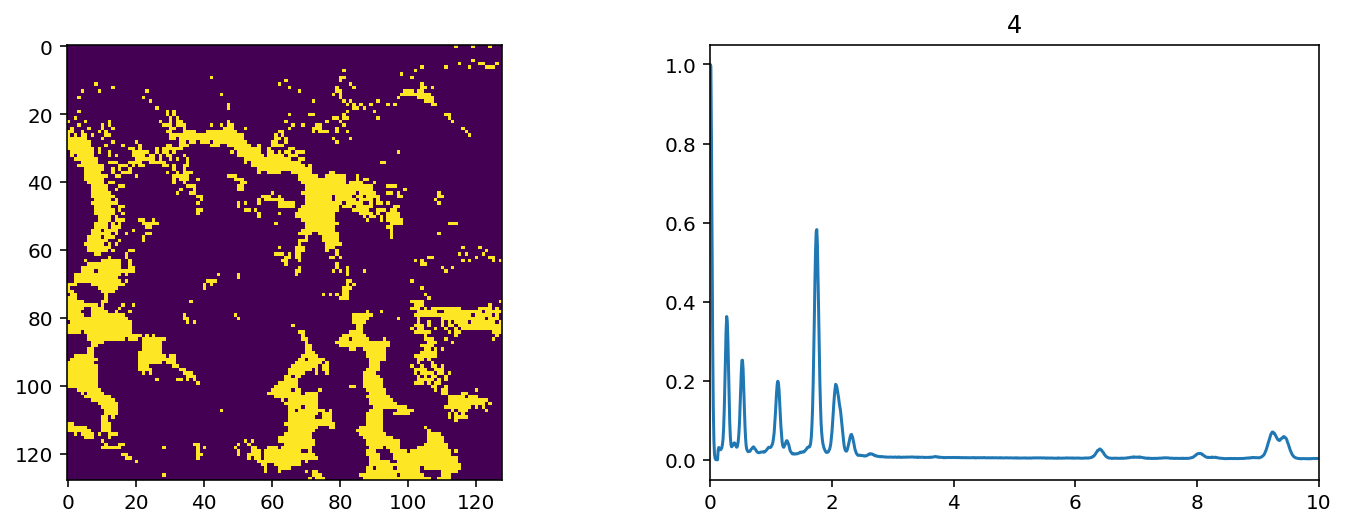

In [12]:
for n in range(len(pca.components_)):
    fig,ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].imshow(phaselegend==n)
    Spc = np.sum(Full[:,phaselegend==n], axis=1)
    OD = Spc
    OD -= np.min(OD) 
    OD = OD / np.max(OD)
    ax[1].plot(E, OD)
    plt.title(n)
    plt.savefig(os.path.join(OutputDir, f'phase{n}_view.png'), dpi=300)
    imsave(os.path.join(OutputDir, f'phase{n}_mask.png'), phaselegend==n, cmap='gray')
    plt.xlim(0,10)
    SpecOut = np.stack((E,OD), axis=1)
    np.savetxt(os.path.join(OutputDir, f'phase{n}_spec.txt'), SpecOut)
plt.show()

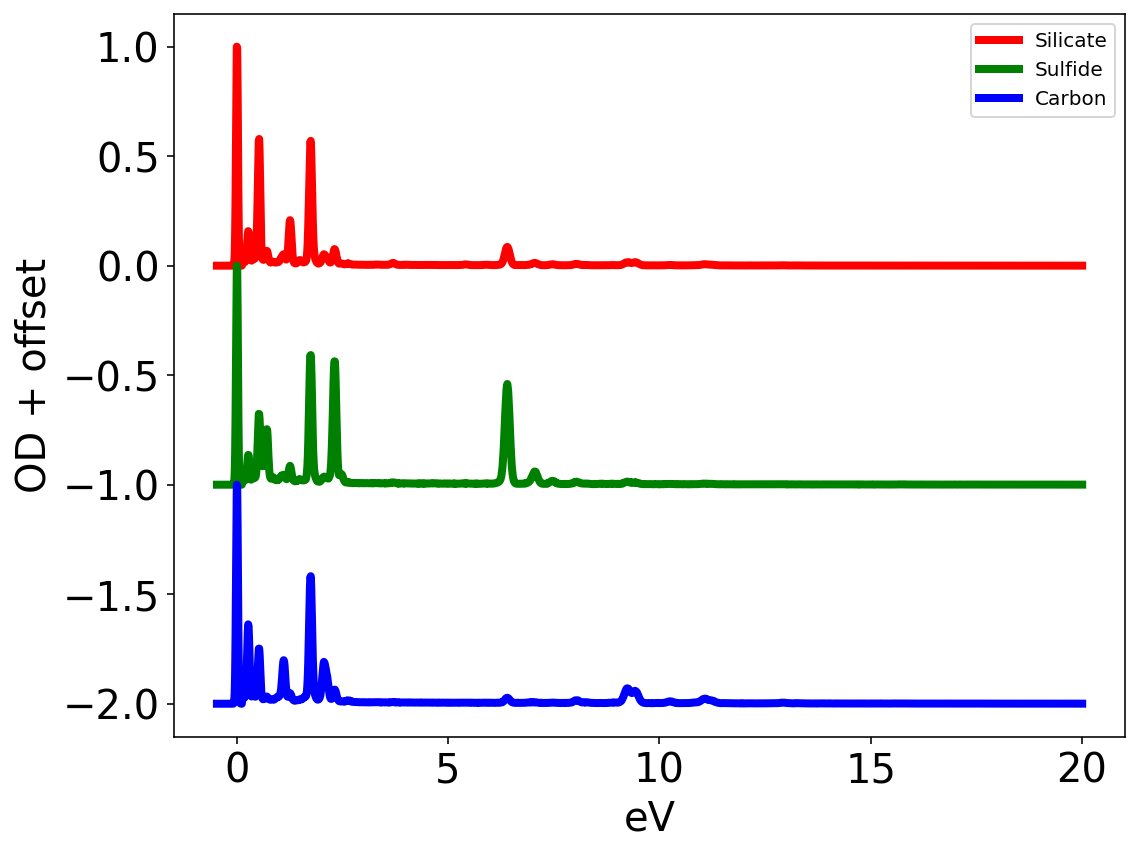

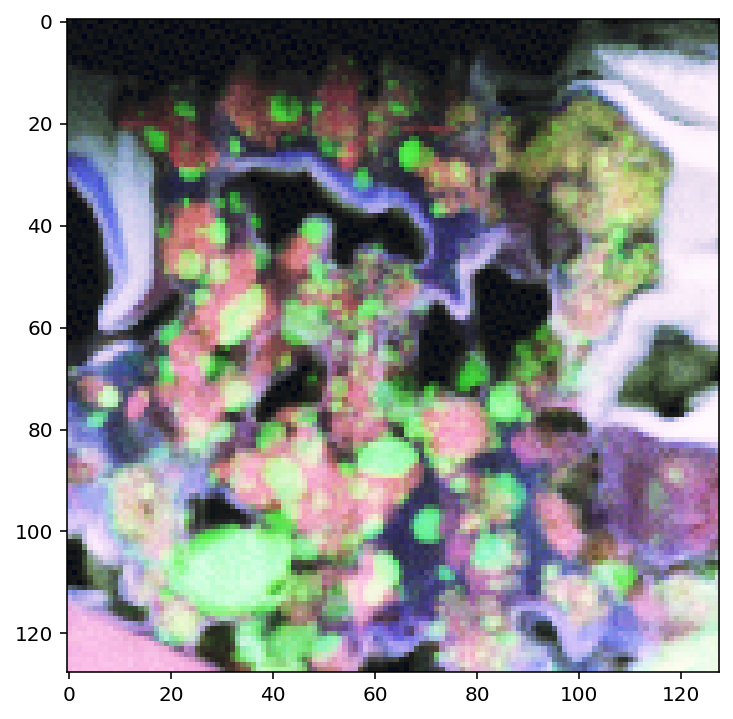

In [14]:
phasenums = [0, 2, 4]
legendstrs = ['Silicate', 'Sulfide', 'Carbon']
colors = ['red', 'green', 'blue']

if not os.path.exists(os.path.join(OutputDir, 'RGB')):
    os.mkdir(os.path.join(OutputDir, 'RGB'))

for i, n in enumerate(phasenums):
    Spc = np.sum(Full[:,phaselegend==n], axis=1)
    OD = Spc; OD -= np.min(OD); OD = OD / np.max(OD)
    
    plt.plot(E, OD-i, color=colors[i], linewidth=4)

# Set the tick labels font
for label in (plt.gca().get_xticklabels() + plt.gca().get_yticklabels()):
    label.set_fontsize(20)
    
plt.xlabel('eV', fontsize=20)
plt.ylabel('OD + offset', fontsize=20)
plt.gcf().patch.set_alpha(1)
plt.legend(legendstrs, )
#plt.gca().set_xlim([525,585])
plt.tight_layout()
plt.savefig(os.path.join(OutputDir, 'RGB', f'Spectra_Phases_{phasenums[0]}_{phasenums[1]}_{phasenums[2]}.tif'), dpi=300)

def NormSig(Sig):
    Sig -= np.min(Sig)
    Sig /= (np.max(Sig))
    return Sig

eq = lambda x: np.cbrt(x)
from skimage.exposure import equalize_hist as eq
# can also try adjust_sigmoid, adjust_gamma, adjust_log, equalize_hist

plt.figure()
phasesrgb = np.zeros((phases2.shape[1],phases2.shape[2],3))
phasesrgb[:,:,0] = eq(NormSig(phases2[phasenums[0],:,:]))
phasesrgb[:,:,1] = eq(NormSig(phases2[phasenums[1],:,:]))
phasesrgb[:,:,2] = eq(NormSig(phases2[phasenums[2],:,:]))
plt.imshow(phasesrgb)
plt.savefig(os.path.join(OutputDir, 'RGB', f'RGB_Phases_{phasenums[0]}_{phasenums[1]}_{phasenums[2]}.tif'), dpi=300)
plt.show()

In [35]:
!jupyter nbconvert --to html 'Decomposition on EDS map.ipynb'

[NbConvertApp] Converting notebook Decomposition on EDS map.ipynb to html
[NbConvertApp] Writing 1521599 bytes to Decomposition on EDS map.html
